# FIT3182 Assignment Part B

- Name: Tan Chong Ern
- Student ID: 31435661
- Email: ctan0119@student.monash.edu
---

## Task 2. Data Visualisation

### *1. Streaming data visualisation* 
*a. For the incoming climate data plot the line graph of air temperature against arrival time. You need to label some interesting points such as maximum and minimum values.*

In [1]:
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import statistics
from json import loads
import pymongo
from pprint import pprint
import folium

<IPython.core.display.Javascript object>


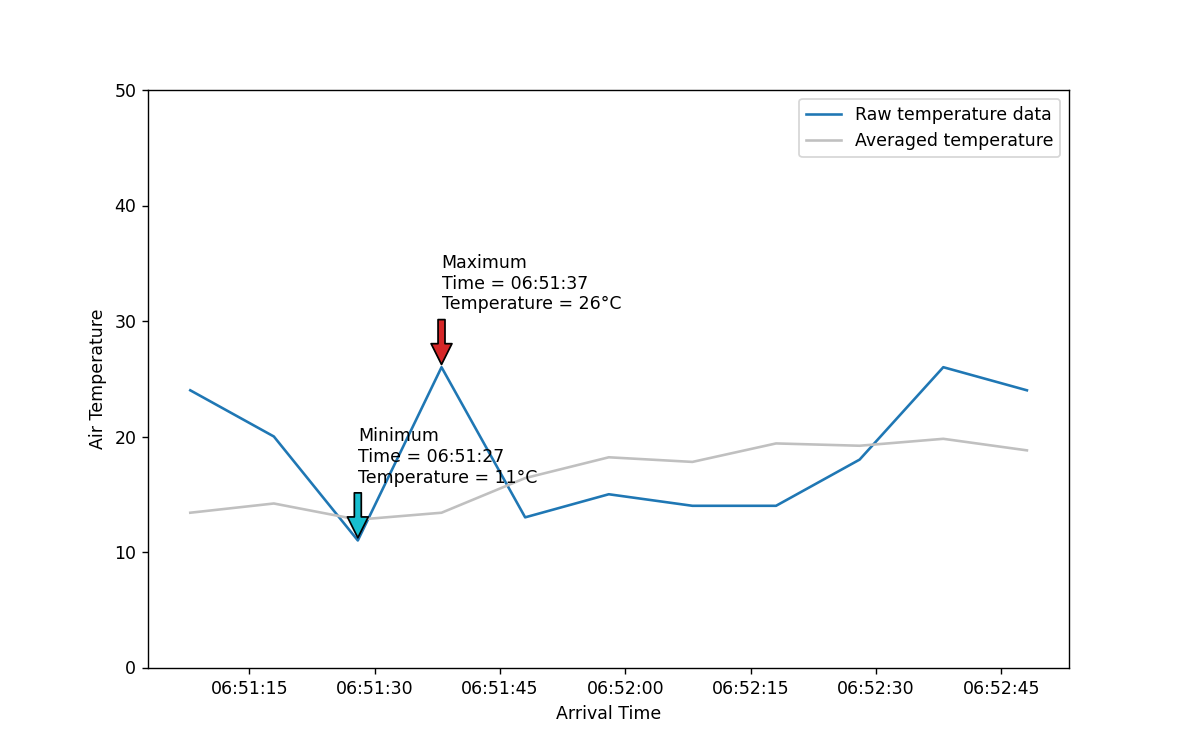

Kafka consumption stopped!


In [2]:
%matplotlib notebook

def connect_kafka_consumer():
    consumer = None
    topic = 'climate_producer'
    try:
         consumer = KafkaConsumer(topic,
                                  consumer_timeout_ms=20000, # stop iteration if no new message after 20 sec
                                  auto_offset_reset='earliest', 
                                  bootstrap_servers=['127.0.0.1:9092'],
                                  api_version=(0, 10))
    except Exception as e:
        print(f'Exception while connecting Kafka: {e}')
    finally:
        return consumer

def init_plots():
    try:
        fig = plt.figure(figsize = (9.5, 6)) # create a new figure
        fig.subplots_adjust(hspace = 0.8)
        ax = fig.add_subplot(111)
        ax.set_xlabel('Date')
        ax.set_ylabel('Air Temperature')
        ax.set_title('Real-time climate data visualization of air temperature against arrival time')
        fig.show() # display the figure
        fig.canvas.draw() # draw on the figure's canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xmax = x[y.index(ymax)]
    text = 'Maximum\nTime = {}\nTemperature = {}°C'.format(xmax.strftime('%H:%M:%S'), ymax)
    if not ax:
        ax = plt.gca() # get the current axes or create one if it doesn't exist
    ax.annotate(text, 
                xy=(xmax, ymax), 
                xytext=(xmax, ymax+5), 
                arrowprops=dict(facecolor='tab:red', shrink=0.05))
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xmin = x[y.index(ymin)]
    text = 'Minimum\nTime = {}\nTemperature = {}°C'.format(xmin.strftime('%H:%M:%S'), ymin)
    if not ax:
        ax = plt.gca() # get the current axes or create one if it doesn't exist
    ax.annotate(text, 
                xy=(xmin, ymin), 
                xytext=(xmin, ymin+5), 
                arrowprops=dict(facecolor='tab:cyan', shrink=0.05))
    
def consume_messages(consumer, fig, ax):
    try:
        x1, y1, y2 = [], [], [] # list for x coordinates, y coordinates, and y average values
        for message in consumer:
            data = loads(message.value.decode('utf-8'))
            x1.append(dt.datetime.now()) 
            y1.append(data['air_temperature_celcius'])
            y2.append(statistics.mean(y1[:5]) if len(y1) > 5 else 0)
            
            # start plotting once there are at least 10 data points
            if len(y1) > 10:
                ax.clear()
                ax.plot(x1, y1)
                ax.plot(x1, y2, color = 'silver')
                ax.set_xlabel('Arrival Time')
                ax.set_ylabel('Air Temperature')
                ax.set_ylim(0, 50)
                ax.legend(('Raw temperature data', 'Averaged temperature'))
                annotate_max(x1, y1, ax)
                annotate_min(x1, y1, ax)
            
                fig.canvas.draw()
                # remove the item in the first position for each list
                x1.pop(0) 
                y1.pop(0)
                y2.pop(0)
                
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    fig, ax = init_plots()
    consumer = connect_kafka_consumer()
    try:
        consume_messages(consumer, fig, ax)
    except KeyboardInterrupt as e:
        print('Kafka consumption stopped!')

Upon running the above code, the resulting line graph should look something like this:

*(Note that if there is past data stored in the Kafka consumer, the line graph would look a bit odd until the streaming data has caught up since the x-coordinates of the temperature values are determined by the current arrival time when the topic's messages are read. Moreover, the averaged temperature shows the average over the last 10 temperature values up until the associated arrival time.)*

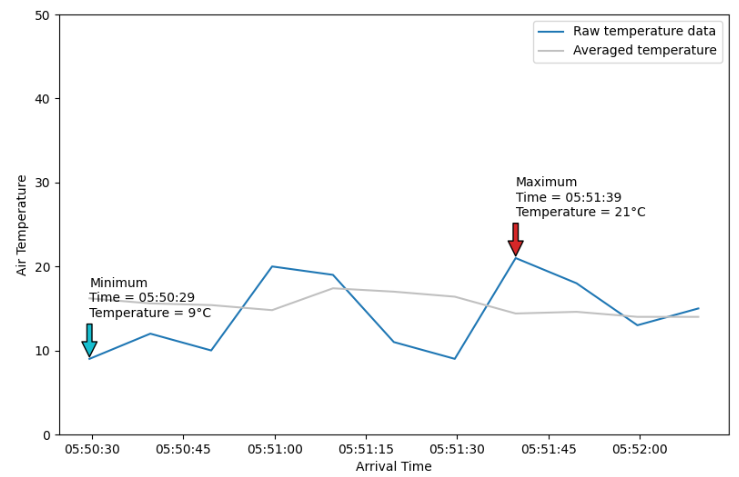

---

### *2. Static data visualisation* 
*a. Plot a bar chart to visualize the total number of fire records based on each hour.*

<IPython.core.display.Javascript object>


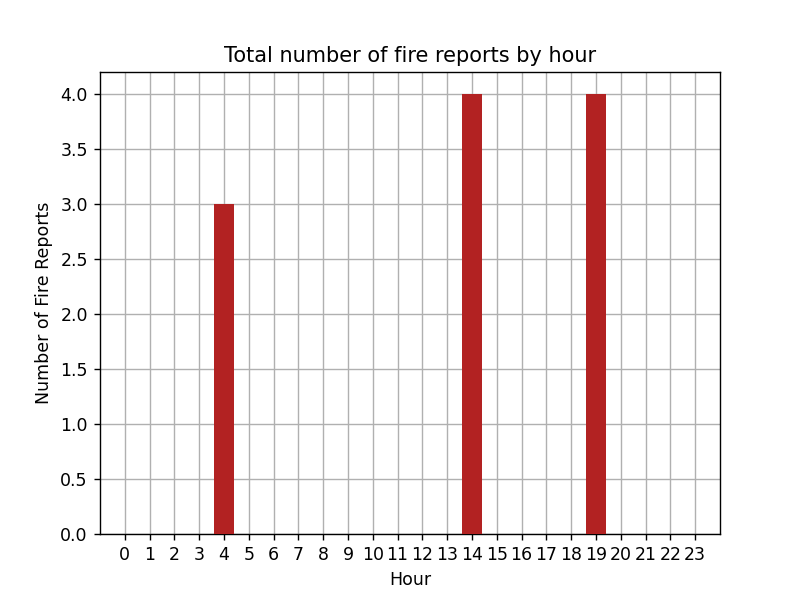

In [3]:
%matplotlib notebook

client = pymongo.MongoClient()
db = client.fit_3182_assignment_db
collection = db.streaming

# unwind the collection by the hotspots and sum the number of records by hours
res = list(collection.aggregate([{'$unwind': '$hotspots'},
                                 {'$group': {'_id': {'time': {'$dateToString': {'format': '%H', 'date': '$hotspots.datetime'}}},
                                             'number_of_fires': {'$sum': 1}}}, 
                                 {'$project': {'number_of_fires': 1, 'time': 1}}]))

res_x, res_y = [x['_id']['time'] for x in res], [y['number_of_fires'] for y in res]
x, y = [hour for hour in range(24)], [0 for _ in range(24)]
for i in range(len(res_x)): # put the result values into the y axis list
    y[int(res_x[i])] = res_y[i]

# plot the bar chart
fig, ax = plt.subplots()
bars = ax.bar(x, y, color = 'firebrick', zorder = 3)
ax.set_xlabel('Hour')
ax.set_ylabel('Number of Fire Reports')
ax.set_xlim(-1, 24)
ax.set_xticks(range(24))
ax.set_title('Total number of fire reports by hour')
ax.grid(zorder = 0)
plt.show()

Upon running the above code, the bar chart should look something like this:

*(Note that the data shown has only 5 bars because it only takes the streaming data and not the historic data.)*

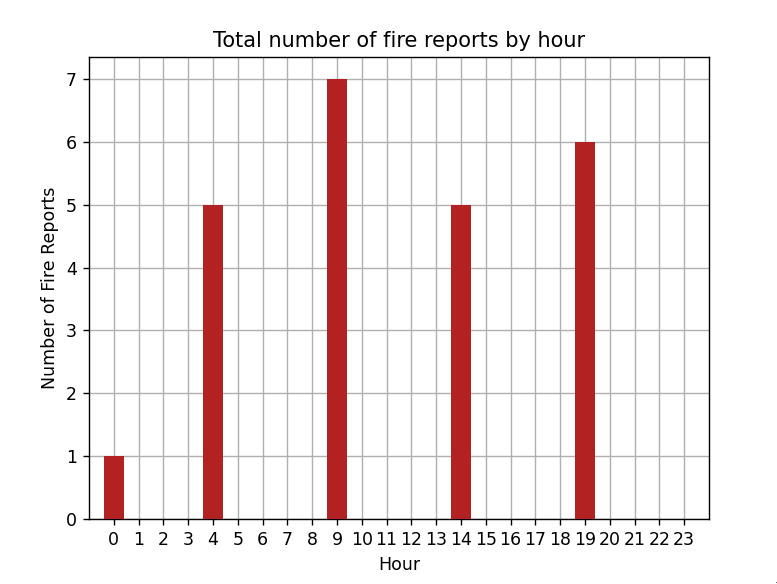

*b. In a map visualize fire locations as markers. Use a ‘blue’ marker if the cause of the fire was ‘natural’. Otherwise, use a ‘red’ marker. Display detailed information such as air temperature, surface temperature, relative humidity and confidence with the marker tooltip.*

In [4]:
client = pymongo.MongoClient()
db = client.fit_3182_assignment_db
collection = db.streaming

# unwinding automatically filters out all data items with empty lists, giving a collection of hotspots
res = list(collection.aggregate([{'$unwind': '$hotspots'}]))

fomap = folium.Map(location=[-36.9848, 143.3906], zoom_start=8)
for data in res: # add marker for each hotspot
    fire = data['hotspots']
    loc = (fire['latitude'], fire['longitude'])
    folium.Marker(location = loc, 
                  popup = f'lat={loc[0]:.2f}, lon={loc[1]:.2f}',
                  icon = folium.Icon(color='blue' if fire['cause'] == 'natural' else 'red'),
                  tooltip = f'''<li>Air Temp: {data['air_temperature_celcius']}°C</li>
                                <li>Surface Temp: {fire['surface_temperature_celcius']}°C</li>
                                <li>Relative Humidity: {data['relative_humidity']}</li>
                                <li>Confidence: {fire['confidence']}%</li>'''
                 ).add_to(fomap)

fomap # show the map

Once again, upon running the above code block, a map of Victoria would be shown with the hotspots' markers from the streaming data as depicted below:

*(Note that the appearance of the marker icons may differ depending on the version of Folium installed.)*

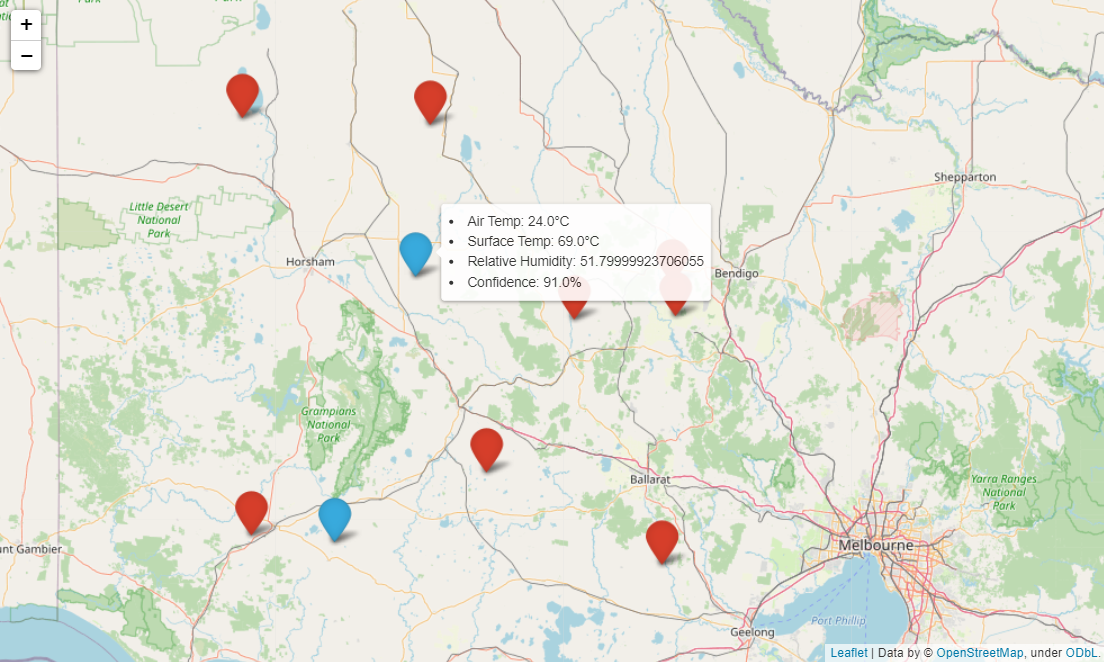